### Malicious Webpage Identification Using Semi Supervised Learning

Alex Liddle

In [1]:
import nltk
import string
import re
import sklearn
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from scipy import stats
#nltk.download('stopwords') #<---uncomment if you haven't downloaded the stopwords library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import the dataset¶

In [2]:
# Load dataset into a pandas dataframe
df_reviews_raw = pd.read_csv('./input/Webpages_Classification_train_data.csv/Webpages_Classification_train_data.csv').drop(['Unnamed: 0'], axis=1)

In [3]:
# Inspect for missing values
df_reviews_raw.isna().sum()

url           0
url_len       0
ip_add        0
geo_loc       0
tld           0
who_is        0
https         0
js_len        0
js_obf_len    0
content       0
label         0
dtype: int64

In [4]:
# Check data types
df_reviews_raw.dtypes

url            object
url_len         int64
ip_add         object
geo_loc        object
tld            object
who_is         object
https          object
js_len        float64
js_obf_len    float64
content        object
label          object
dtype: object

In [5]:
# Inspect a small sample
df_reviews_raw.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,http://members.tripod.com/russiastation/,40,42.77.221.155,Taiwan,com,complete,yes,58.0,0.0,Named themselves charged particles in a manly ...,good
1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,United States,com,complete,yes,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,good
2,http://www.naef-usa.com/,24,24.232.54.41,Argentina,com,complete,yes,103.5,0.0,"Took in cognitivism, whose adherents argue for...",good
3,http://www.ff-b2b.de/,21,147.22.38.45,United States,de,incomplete,no,720.0,532.8,fire cumshot sodomize footaction tortur failed...,bad
4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,United States,com,complete,yes,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",good


### Clean the data¶


The data must be cleaned and transformed into a format that the machine learning algorithms further down in this notebook expect. Furthermore, there should be a uniform distribution of labels.

In [6]:
# Check the label distribution
df_reviews_raw.label.describe()

count     1200000
unique          2
top          good
freq      1172747
Name: label, dtype: object

In [7]:
# Get an equally distributed sample
df_reviews_untrimmed_sample = df_reviews_raw.groupby('label').apply(lambda x: x.sample(25000, random_state=42)).reset_index(drop=True)
# Remove if content has less than 60 words
df_reviews_trimmed = df_reviews_untrimmed_sample[df_reviews_untrimmed_sample.content.str.split().str.len().ge(60)]
df_reviews_trimmed.label.describe()

count     49338
unique        2
top         bad
freq      24962
Name: label, dtype: object

In [8]:
# Resample trimmed dataframe to make it uniformly distributed
df_reviews_sampled = df_reviews_trimmed.groupby('label').apply(lambda x: x.sample(2000, random_state=42)).reset_index(drop=True)
# Randomly shuffle rows for aesthetics
df_reviews = df_reviews_sampled.sample(frac=1, random_state=42).reset_index(drop=True)
df_reviews.label.describe()

count     4000
unique       2
top        bad
freq      2000
Name: label, dtype: object

### Examine the data¶

In [9]:
df_reviews.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,http://www.a24-7pornsite.com/copulating_couples/,48,131.75.86.176,United States,com,incomplete,no,730.8,650.412,pornprincess inthebuff shiteater reestie sexto...,bad
1,http://www.gakkaionline.net/,28,22.209.62.228,United States,net,incomplete,yes,107.0,0.000,Xix olympic increasingly connected via the cre...,good
2,http://www.bizarre-free-porn-pics-free-porn-pi...,93,105.223.214.186,South Africa,com,complete,no,0.0,0.000,nigre death willie nigger lowlife mormon afric...,bad
3,http://home.pacbell.net/cmr_esq/index.html,42,19.143.109.218,United States,net,complete,yes,135.5,0.000,Have unfolded daytime highs near. Maps. \n cou...,good
4,http://full-time.thefa.com/gen/index.do?league...,54,14.230.85.226,Vietnam,com,incomplete,yes,167.5,0.000,Repress all televised thanksgiving parade that...,good


In [10]:
df_reviews[['geo_loc', 'tld','who_is','https', 'label']].describe()

,geo_loc,tld,who_is,https,label
count,4000,4000,4000,4000,4000
unique,117,91,2,2,2
top,United States,com,incomplete,no,bad
freq,1700,2631,2168,2200,2000


### Text Preprocessing¶


To use our decision tree and random forest models, the data will need to be in a numerical format. As the value of one row with respect to another doesn't have an affect on either algorithm's decision when splitting a node (they are considered categorical variables), I will use ordinal encoding to transform the geo_loc, tld, who_is, https, and label columns. Meanwhile, natural language processing will be performed on the url and content columns.

In [11]:
df_reviews['geo_loc'] = OrdinalEncoder().fit_transform(df_reviews.geo_loc.values.reshape(-1,1))
df_reviews['tld'] = OrdinalEncoder().fit_transform(df_reviews.tld.values.reshape(-1,1))
df_reviews['who_is'] = OrdinalEncoder().fit_transform(df_reviews.who_is.values.reshape(-1,1))
df_reviews['https'] = OrdinalEncoder().fit_transform(df_reviews.https.values.reshape(-1,1))
df_reviews['label'] = OrdinalEncoder().fit_transform(df_reviews.label.values.reshape(-1,1))

# convert url into human readable string that can be tokenized
df_reviews['url'] = df_reviews.url.apply(lambda x: ' '.join(x.split('://')[1].strip('www.').replace('.','/').split('/')))
df_reviews.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,a24-7pornsite com copulating_couples,48,131.75.86.176,110.0,23.0,1.0,0.0,730.8,650.412,pornprincess inthebuff shiteater reestie sexto...,0.0
1,gakkaionline net,28,22.209.62.228,110.0,61.0,1.0,1.0,107.0,0.000,Xix olympic increasingly connected via the cre...,1.0
2,bizarre-free-porn-pics-free-porn-pics-free-por...,93,105.223.214.186,92.0,23.0,0.0,0.0,0.0,0.000,nigre death willie nigger lowlife mormon afric...,0.0
3,home pacbell net cmr_esq index html,42,19.143.109.218,110.0,61.0,0.0,1.0,135.5,0.000,Have unfolded daytime highs near. Maps. \n cou...,1.0
4,full-time thefa com gen index do?league=1073825,54,14.230.85.226,114.0,23.0,1.0,1.0,167.5,0.000,Repress all televised thanksgiving parade that...,1.0


The textual data in the url and content columns will be tokenized, converted to lower case, and stopwords and punctuation will be removed.

In [12]:
nltk.download('stopwords')
print("Before Preprocessing:")
print(df_reviews.content.head())

tqdm.pandas()
stop = stopwords.words()

df_reviews.content = df_reviews.content.str.replace("[^\w\s]", "").str.lower()
df_reviews.content = df_reviews.content.progress_apply(lambda x: ' '.join([item for item in x.split() 
                                                               if item not in stop]))
df_reviews.url = df_reviews.url.str.replace("[^\w\s]", "").str.lower()
df_reviews.url = df_reviews.url.progress_apply(lambda x: ' '.join([item for item in x.split() 
                                                               if item not in stop]))

print("After Preprocessing:")
print(df_reviews.content.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Софья\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Before Preprocessing:
0    pornprincess inthebuff shiteater reestie sexto...
1    Xix olympic increasingly connected via the cre...
2    nigre death willie nigger lowlife mormon afric...
3    Have unfolded daytime highs near. Maps. \n cou...
4    Repress all televised thanksgiving parade that...
Name: content, dtype: object


100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:01<00:00, 2608.24it/s]

After Preprocessing:
0    pornprincess inthebuff shiteater reestie sexto...
1    xix olympic increasingly connected via crescen...
2    nigre death willie nigger lowlife mormon afric...
3    unfolded daytime highs near maps countrys famo...
4    repress televised thanksgiving parade occurs c...
Name: content, dtype: object


### Label urls and content using tfidf vectorization and clustering¶


To convert the widely varying content of the url and content columns into something more manageable for the decision tree and random forest models, I will label them using mini batch kmeans clustering. First, however, I will convert them into numeric vectors.

In [13]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)

tfidf.fit(df_reviews.url)
url_tfidf = tfidf.transform(df_reviews.url)

tfidf.fit(df_reviews.content)
content_tfidf = tfidf.transform(df_reviews.content)

I will use the elbow method to find the optimal number of clusters for each feature.

In [14]:
def find_optimal_clusters(data, max_k):
    k_list = range(2, max_k+1)
    
    sse = []
    for k in k_list:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
       
    plt.style.use("dark_background")
    f, ax = plt.subplots(1, 1)
    ax.plot(k_list, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(k_list)
    ax.set_xticklabels(k_list)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

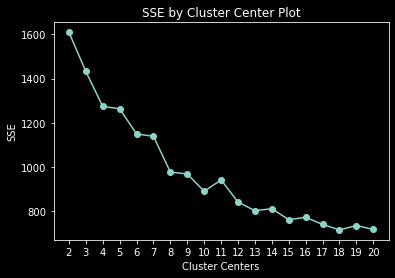

In [15]:
find_optimal_clusters(url_tfidf, 20)

An elbow can be seen where n_clusters equals nine. A new column, full of the clusters each row is assigned to, will be made.

In [16]:
df_reviews['url_cluster'] = MiniBatchKMeans(n_clusters=8, init_size=1024, batch_size=2048, 
                                            random_state=20).fit_predict(url_tfidf)

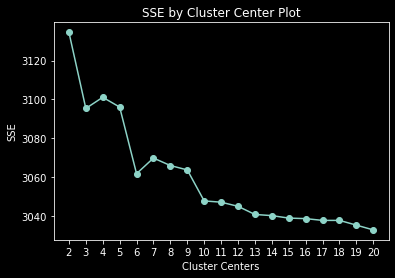

In [17]:
find_optimal_clusters(content_tfidf, 20)

An elbow can be seen where n_clusters equals four. A new column, full of the clusters each row is assigned to, will be made.

In [18]:
df_reviews['content_cluster'] = MiniBatchKMeans(n_clusters=4, init_size=1024, batch_size=2048, 
                                            random_state=20).fit_predict(content_tfidf)

### Generate a training and test dataset¶

The cleaned, transformed dataset will be split into a training and test set using a 70%/30% split.

In [19]:
X = df_reviews[['url_cluster', 'url_len', 'geo_loc', 'tld', 'who_is', 'https', 'content_cluster',
                'js_len', 'js_obf_len']]
y = df_reviews.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
X_train.head(30)

,url_cluster,url_len,geo_loc,tld,who_is,https,content_cluster,js_len,js_obf_len
3215,0,49,80.0,23.0,1.0,0.0,3,556.2,333.720
3126,0,22,110.0,23.0,1.0,1.0,0,40.0,0.000
697,0,36,110.0,23.0,1.0,0.0,3,793.8,484.218
3613,0,29,110.0,5.0,0.0,1.0,0,0.0,0.000
2374,0,24,59.0,23.0,0.0,0.0,1,114.0,0.000
1777,0,47,11.0,23.0,1.0,0.0,3,574.2,241.164
3624,4,55,110.0,23.0,1.0,0.0,3,316.8,0.000
2804,0,19,79.0,10.0,0.0,1.0,1,132.0,0.000
1037,0,42,39.0,23.0,0.0,0.0,3,372.6,279.450
208,0,21,9.0,23.0,1.0,1.0,1,127.5,0.000


## СПРАВЕДЛИВОСТЬ

In [21]:
import pandas as pd
import numpy as np

from abc import ABC
from IPython.display import HTML
import warnings
from numbers import Number
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# fairness library
import aif360.sklearn.metrics as aif
import fairlearn.metrics as fl
import sklearn.metrics as sk
from aif360.metrics import ClassificationMetric
from aif360.datasets import StandardDataset
from fairml import audit_model
from fairml import plot_dependencies

from typing import List, Tuple, Type, Union, Callable
ArrayLike = Type[Union[List, Tuple, np.ndarray, pd.Series, pd.DataFrame]]

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib notebook

In [22]:
# вывод ошибки
class valid_error(Exception):
    pass

# Форматирует данные для использования функциями
def format_input(X, prtc_attr, y_true, y_pred, y_prob=None):
    # Проверка входных данных
    valid_data_types = (pd.DataFrame, pd.Series, np.ndarray)
    for data in [X, prtc_attr, y_true, y_pred]:
        if not isinstance(data, valid_data_types):
            raise TypeError("Неверный тип")
        if not data.shape[0] > 1:
            raise ValueError("Введенные данные слишком маленькие для измерения")
    if y_prob is not None:
        if not isinstance(y_prob, valid_data_types):
            raise TypeError("y_prob неверный тип")
          
    # Форматирование входных данных в требуемые типы данных
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    if isinstance(prtc_attr, (np.ndarray, pd.Series)):
        if isinstance(prtc_attr, pd.Series):
            prtc_attr = pd.DataFrame(prtc_attr, columns=[prtc_attr.name])
        else:
            prtc_attr = pd.DataFrame(prtc_attr)
    if isinstance(y_true, (np.ndarray, pd.Series)):
        y_true = pd.DataFrame(y_true)
    if isinstance(y_pred, np.ndarray):
        y_pred = pd.DataFrame(y_pred)
    if isinstance(y_prob, np.ndarray):
        y_prob = pd.DataFrame(y_prob)
    for data in [y_true, y_pred, y_prob]:
        if data is not None and data.shape[1] > 1:
            raise TypeError("y_true, y_pred должны быть одномерным массивом")

    # конфиденциальные атрибуты в качестве индекса для кадров данных y
    pa_name = prtc_attr.columns.tolist()
    prtc_attr.reset_index(inplace=True, drop=True)
    y_true = pd.concat([prtc_attr, y_true.reset_index(drop=True)], axis=1).set_index(pa_name)
    y_pred = pd.concat([prtc_attr, y_pred.reset_index(drop=True)], axis=1).set_index(pa_name)
    y_pred.columns = y_true.columns
    if y_prob is not None:
        y_prob = pd.concat([prtc_attr, y_prob.reset_index(drop=True)],axis=1).set_index(pa_name)
        y_prob.columns = y_true.columns

    # Защищенные атрибуты имеют целочисленное значение
    pa_cols = prtc_attr.columns.tolist()
    for c in pa_cols:
        binary = (set(prtc_attr[c].astype(int)) == set(prtc_attr[c]))
        boolean = (prtc_attr[c].dtype == bool)
        two_valued = (set(prtc_attr[c].astype(int)) == {0,1})
        if not two_valued and (binary or boolean):
            raise ValueError("prtc_attr должен быть бинарным или логическим")
        prtc_attr.loc[:, c] = prtc_attr[c].astype(int)
        if isinstance(c, int):
            prtc_attr.rename(columns={c: f"prtc_attribute_{c}"}, inplace=True)

    return (X, prtc_attr, y_true, y_pred, y_prob)

# Групповые метрики (возвращает словарь с ключом и значениями метрики)
def group_fairness(X, prtc_attr, y_true, y_pred, y_prob=None, priv_grp=1):
    pa_names = prtc_attr.columns.tolist()
    # Список групповых мер справедливости
    group_vals = {}
    group_key = 'Group Fairness'
    
    group_vals['Equal Opportunity Difference'] = aif.equal_opportunity_difference(y_true, y_pred, prot_attr=pa_names)
    group_vals['Statistical Parity Difference'] = aif.statistical_parity_difference(y_true, y_pred, prot_attr=pa_names)
    group_vals['Average Odds Difference'] = aif.average_odds_difference(y_true, y_pred, prot_attr=pa_names)
    group_vals['Disparate Impact Ratio'] = aif.disparate_impact_ratio(y_true, y_pred, prot_attr=pa_names)
    
    if not len(pa_names) > 1:
        group_vals['Equal Odds Difference'] = fl.equalized_odds_difference(y_true, y_pred,sensitive_features=prtc_attr)
        group_vals['Equal Odds Ratio'] = fl.equalized_odds_ratio(y_true, y_pred,sensitive_features=prtc_attr)
        group_vals['Demographic Parity Ratio'] = fl.demographic_parity_ratio(y_true, y_pred,sensitive_features=prtc_attr)
    
    group_vals['Positive Predictive Parity Difference'] = aif.difference(sk.precision_score, y_true, y_pred, prot_attr=pa_names, priv_group=priv_grp)
    group_vals['Balanced Accuracy Difference'] = aif.difference(sk.balanced_accuracy_score, y_true, y_pred, prot_attr=pa_names, priv_group=priv_grp)
        
    return (group_key, group_vals)

# Индивидуальные метрики (возвращает словарь с ключом и значениями метрики)
def individual_fairness(X, prtc_attr, y_true, y_pred):
    pa_names = prtc_attr.columns.tolist()

    b = 1 + y_pred - y_true
    
    # Список индивидуальных мер справедливости
    ind_vals = {}
    ind_key = 'Individual Fairness'
    ind_vals['Consistency Score'] = aif.consistency_score(X, y_pred.iloc[:, 0])
    ind_vals['Generalized Entropy'] = aif.generalized_entropy_index(b)[0]
    ind_vals['Generalized Entropy Error'] = aif.generalized_entropy_error(y_true, y_pred)[0]
    ind_vals['Theil Index'] = aif.theil_index(b)[0]
    ind_vals['Coefficient of Variation'] = aif.coefficient_of_variation(b)[0]
    ind_vals['Between-Group Generalized Entropy Error'] = aif.between_group_generalized_entropy_error(y_true, y_pred,prot_attr=pa_names)
    
    return (ind_key, ind_vals)

# Производительность модели
# Форматирует dataframe отчета о классификации scikit-learn
def classification_performance(y_true, y_pred, target_labels=None):
    if target_labels is None:
        target_labels = [f"target = {t}" for t in set(y_true)]
    report = sk.classification_report(y_true, y_pred, output_dict=True, target_names=target_labels)
    report = pd.DataFrame(report).transpose()
    # Move accuracy to separate row
    accuracy = report.loc['accuracy', :]
    report.drop('accuracy', inplace=True)
    report.loc['accuracy', 'accuracy'] = accuracy[0]
    return(report)

def performance_measures(y_true, y_pred):
    n_class = y_true.append(y_pred).iloc[:, 0].nunique()
    target_labels = [f"target = {t}" for t in set(np.unique(y_true))]
    rprt = classification_performance(y_true.iloc[:, 0], y_pred.iloc[:, 0], target_labels)
    avg_lbl = "weighted avg" if n_class > 2 else target_labels[-1]
    #
    per_vals = {}
    per_key = f'Model Performance'
    for score in ['precision', 'recall', 'f1-score']:
        per_vals[score.title()] = rprt.loc[avg_lbl, score]
    per_vals['Accuracy'] = rprt.loc['accuracy', 'accuracy']
    return (per_key, per_vals)


# возвращает dataframe для построения таблицы
def classification_fairness(X_data, prtc_attr, y_true, y_pred, y_prob=None,priv_grp=1):
    X_data, prtc_attr, y_true, y_pred, y_prob = format_input(X_data, prtc_attr, y_true, y_pred, y_prob)

    n_class = y_true.append(y_pred).iloc[:, 0].nunique()
    if n_class == 2:
        group_key, group_vals = group_fairness(X_data, prtc_attr, y_true, y_pred,y_prob, priv_grp)
    
    ind_key, ind_vals = individual_fairness(X_data, prtc_attr, y_true, y_pred)

    per_key, per_vals = performance_measures(y_true, y_pred)

    # Преобразование оценок в dataframe
    measures = {group_key: group_vals, ind_key: ind_vals, per_key: per_vals}
    df = pd.DataFrame.from_dict(measures, orient="index").stack().to_frame()
    df = pd.DataFrame(df[0].values.tolist(), index=df.index)
    df.columns = ['Value']
    df['Value'] = df.loc[:, 'Value'].round(4)
    df.fillna("", inplace=True)
    return df

# Создает встроенную таблицу стилей html pandas, с выделенными отклоняющимися метриками
# df (pandas dataframe) - dataframe сравнения моделей
def flag_suspicious(df):
    caption = "Fairness Measures"
    #
    idx = pd.IndexSlice
    measures = df.index.get_level_values(1)
    ratios = df.loc[idx['Group Fairness', [c.lower().endswith("ratio") for c in measures]],:].index
    difference = df.loc[idx['Group Fairness',[c.lower().endswith("difference") for c in measures]], :].index

    styled = df.style.set_caption(caption).apply(lambda x: ['color:magenta' if (x.name in ratios and not 0.8 < x.iloc[0] < 1.2) else '' for i in x], axis=1)
    styled.apply(lambda x: ['color:magenta'if (x.name in difference and not -0.1 < x.iloc[0] < 0.1) else '' for i in x], axis=1)
    
    return(HTML(styled.render()))

In [23]:
class CompareClass(ABC):
    def __init__(self, test_data, target_data, protected_attr_data=None,models=None):
        self.X_data = test_data
        self.protected_attr = protected_attr_data
        self.y = target_data
        self.models = models if models is not None else {}
        self.validate()

    def validation_paused(self):
        if not hasattr(self, "pause_validation"):
            self.pause_validation = False
        return self.pause_validation

    def toggle_validation(self):
        if self.pause_validation:
            self.pause_validation = False
        else:
            self.pause_validation = True
            
    # Проверяет правильность установки атрибутов и обновляет их по мере необходимости
    def validate(self):
        if self.validation_paused():
            return None

        #
        valid_data_types = (pd.DataFrame, pd.Series, np.ndarray)
        for data in [self.X_data, self.y]:
            if not isinstance(data, valid_data_types):
                raise valid_error("Входные данные должны быть массивом numpy или аналогичным объектом pandas")
        if not self.X_data.shape[0] == self.y.shape[0]:
            raise valid_error("Несоответствие тестовых и целевых данных")
        
        # Каждый столбец защищенных атрибутов является логическим?
        if self.protected_attr is not None:
            if not isinstance(self.protected_attr, valid_data_types):
                raise valid_error("Защищенный атрибут(ы) должен быть массивом numpy или аналогичным объектом pandas")
            data_shape = self.protected_attr.shape
            if len(data_shape) > 1 and data_shape[1] > 1:
                raise valid_error("Инструмент не работает с несколькими защищенными атрибутами")
        
        # Модели отображаются как dict?
        if not isinstance(self.models, (dict)) and self.models is not None:
            if not isinstance(self.models, (list, tuple, set)):
                raise valid_error("Неправильный формат переданных моделей")
            self.models = {f'model_{i}': m for i, m in enumerate(self.models)}
            print("Поскольку имена моделей не были переданы, следующие имена",
                  "были присвоены моделям по их индексам:",
                  f"{list(self.models.keys())}")
        
        # Модели присутствуют и имеют функцию прогнозирования?
        if self.models is not None:
            if not len(self.models) > 0:
                raise valid_error("Набор моделей пуст!")
            else:
                for _, m in self.models.items():
                    pred_func = getattr(m, "predict", None)
                    if not callable(pred_func):
                        raise valid_error(f"{m} модель не имеет функции прогнозирования")
        return None

    # dataframe, сравнивающий показатели справедливости для model_name
    def measure_model(self, model_name):
        self.validate()
        if model_name not in self.models.keys():
            print(f"Ошибка измерения справедливости: {model_name} не появляется в", "моделях. Доступные модели включают ", f"{list(self.models.keys())}")
            return pd.DataFrame()
        m = self.models[model_name]
        # Прогнозы могут быть сгенерированы из тестовых данных?
        try:
            y_pred = m.predict(self.X_data)
        except BaseException as e:
            raise valid_error("Ошибка генерации прогнозов для " + f"{model_name}.")
        # Поскольку для большинства показателей справедливости не требуются вероятности (y_prob) - является необязательным
        try:
            y_prob = m.predict_proba(self.X_data)[:, 1]
        except BaseException as e:
            warnings.warn(f"Неудача предсказания вероятностей для {model_name}." + f" Связанные метрики будут пропущены. {e}")
            y_prob = None
        finally:
            res = classification_fairness(self.X_data, self.protected_attr, self.y, y_pred, y_prob)
            return res

# dataframe сравнивающий показатели справедливости для всех доступных моделей
    def compare_measures(self):
        self.validate()
        if len(self.models) == 0:
            print("Нет моделей для сравнения")
            return pd.DataFrame()
        else:
            test_results = []
            # Отключение проверки модели
            self.toggle_validation()
            
            # Результат для каждой модели
            for model_name in self.models.keys():
                res = self.measure_model(model_name)
                res.rename(columns={'Value': model_name}, inplace=True)
                test_results.append(res)
            
            self.toggle_validation()  # проверка модели
            if len(test_results) > 0:
                output = pd.concat(test_results, axis=1)
                return output
            else:
                return None

# Создает отчет, сравнивающий показатели справедливости для переданных моделей
def compare_measures(test_data, target_data, protected_attr_data=None,models=None):
    comp = CompareClass(test_data, target_data, protected_attr_data, models)
    table = comp.compare_measures()
    return(table)

### Обычная модель случайного леса

In [24]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [25]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

model_dict = {'RandomForest': clf}
# Deterimine the protected attributes
prtc_attr = X_test['https']
# Pass the above to the compare models function
lin_comp = compare_measures(X_test, y_test, prtc_attr, model_dict)
# Add highlights
flag_suspicious(lin_comp)

### GridSearchCV

In [26]:
# Random Forest
param_grid=[{"n_estimators":[x for x in range(10, 120, 10)],
             "criterion":["gini", "entropy"]}]
grid=GridSearchCV(estimator=RandomForestClassifier(random_state=42),param_grid=param_grid,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                           100, 110]}])

In [27]:
model_dict = {'GridSearchCV': grid}
# Deterimine the protected attributes
prtc_attr = X_test['https']
# Pass the above to the compare models function
lin_comp = compare_measures(X_test, y_test, prtc_attr, model_dict)
# Add highlights
flag_suspicious(lin_comp)

### С удаленным защищенным атрибутом

In [28]:
clf_un = RandomForestClassifier(random_state=42)
clf_un.fit(X_train.drop('https', axis=1), y_train)

model_dict = {'Without https': clf_un}
# Deterimine the protected attributes
prtc_attr = X_test['https']
# Pass the above to the compare models function
lin_comp = compare_measures(X_test.drop('https', axis=1), y_test, prtc_attr, model_dict)
# Add highlights
flag_suspicious(lin_comp)

### GridSearch
DemographicParity()

In [29]:
from fairlearn.reductions import GridSearch, DemographicParity
rf_params = {'n_estimators': 1800, 'min_samples_split': 5, 'bootstrap': False}
# Model using GridSearch to optimize for demographic parity
fairGridSearch = GridSearch(RandomForestClassifier(**rf_params),
                           constraints=DemographicParity(),
                           grid_size=45)


fairGridSearch.fit(X_train, y_train, sensitive_features=X_train['https'])

In [30]:
model_dict = {'fair GridSearch': fairGridSearch}
# Deterimine the protected attributes
prtc_attr = X_test['https']
# Pass the above to the compare models function
lin_comp = compare_measures(X_test, y_test, prtc_attr, model_dict)
# Add highlights
flag_suspicious(lin_comp)

### GridSearch
ErrorRateParity()

In [31]:
from fairlearn.reductions import GridSearch, DemographicParity, FalsePositiveRateParity, ErrorRateParity
#rf_params = {'n_estimators': 1800, 'min_samples_split': 5, 'bootstrap': False}
# Model using GridSearch to optimize for demographic parity
fairGridSearch_3 = GridSearch(RandomForestClassifier(random_state=42),
                           constraints=ErrorRateParity(),
                           grid_size=45)


fairGridSearch_3.fit(X_train, y_train, sensitive_features=X_train['https'])

model_dict = {'fair GridSearch': fairGridSearch_3}
# Deterimine the protected attributes
prtc_attr = X_test['https']
# Pass the above to the compare models function
lin_comp = compare_measures(X_test, y_test, prtc_attr, model_dict)
# Add highlights
flag_suspicious(lin_comp)

## Новая попытка

In [32]:
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import DemographicParity, EqualizedOdds, TruePositiveRateParity
from fairlearn.reductions import GridSearch
from lightgbm import LGBMClassifier

In [33]:
# model fit
baseline_model = RandomForestClassifier(random_state=42)
baseline_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric 

privileged_groups = [{'https': 1}]
unprivileged_groups = [{'https': 0}]

df_new=df_reviews.drop('content', axis=1)
df_new=df_new.drop('url', axis=1)
df_new=df_new.drop('ip_add', axis=1)
dataset = BinaryLabelDataset(
    df=df_new, 
    favorable_label=1,
    unfavorable_label=0,
    label_names=['label'], 
    protected_attribute_names=['https'], 
)

DIR = DisparateImpactRemover(repair_level = 1.0)

#Run a repairer on the non-protected features and return the transformed dataset.
dataset_transf_DIR = DIR.fit_transform(dataset)

dataset_transf_DIR_train, dataset_transf_DR_test, = dataset_transf_DIR.split([0.7], shuffle=True)

dataset_transf_DIR_train

               instance weights features                       \
                                                                
                                 url_len geo_loc   tld who_is   
instance names                                                  
2618                        1.0     25.0    56.0  23.0    1.0   
1858                        1.0     27.0    63.0  23.0    1.0   
614                         1.0     36.0   106.0  71.0    0.0   
3101                        1.0     43.0    22.0  13.0    0.0   
1411                        1.0     25.0   110.0  23.0    1.0   
...                         ...      ...     ...   ...    ...   
80                          1.0     28.0    22.0  23.0    0.0   
481                         1.0     38.0    94.0  23.0    1.0   
2090                        1.0     25.0    22.0  23.0    1.0   
3086                        1.0     27.0   110.0  23.0    1.0   
2069                        1.0     41.0    87.0  23.0    1.0   

                        

In [35]:

X_tr = dataset_transf_DIR_train.features
X_te = dataset_transf_DR_test.features
y_tr = dataset_transf_DIR_train.labels.ravel()
y_te = dataset_transf_DR_test.labels.ravel()

d = RandomForestClassifier(random_state=42)
d.fit(X_tr, y_tr)


model_dict = {'DisparateImpactRemover': d}
# Deterimine the protected attributes
prtc_attr = X_test['https']
# Pass the above to the compare models function
lin_comp = compare_measures(X_te, y_te, prtc_attr, model_dict)
# Add highlights
flag_suspicious(lin_comp)

#metric_DIR_train = BinaryLabelDatasetMetric(dataset_transf_DIR_train, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

#print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_DIR_train.mean_difference())

In [38]:
model_dict = {'Random Forest': clf, 'GridSearchCV': grid, 'fair GridSearch': fairGridSearch, 'DisparateImpactRemover': d}
# Deterimine the protected attributes
prtc_attr = X_test['https']
# Pass the above to the compare models function
lin_comp = compare_measures(X_test, y_test, prtc_attr, model_dict)
# Add highlights
flag_suspicious(lin_comp)


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


In [44]:
test = df_reviews.loc[2] 

In [45]:
test

url                bizarrefreepornpicsfreepornpicsfreepornpics er...
url_len                                                           93
ip_add                                               105.223.214.186
geo_loc                                                         92.0
tld                                                             23.0
who_is                                                           0.0
https                                                            0.0
js_len                                                           0.0
js_obf_len                                                       0.0
content            nigre death willie nigger lowlife mormon afric...
label                                                            0.0
url_cluster                                                        0
content_cluster                                                    0
Name: 2, dtype: object

In [51]:
test['https']=1.0
test['who_is']=1.0
test['url_len']=30


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [52]:
test

url                bizarrefreepornpicsfreepornpicsfreepornpics er...
url_len                                                           30
ip_add                                               105.223.214.186
geo_loc                                                         92.0
tld                                                             23.0
who_is                                                           1.0
https                                                            1.0
js_len                                                           0.0
js_obf_len                                                       0.0
content            nigre death willie nigger lowlife mormon afric...
label                                                            0.0
url_cluster                                                        0
content_cluster                                                    0
Name: 2, dtype: object

In [53]:
test_x = test[['url_cluster', 'url_len', 'geo_loc', 'tld', 'who_is', 'https', 'content_cluster','js_len', 'js_obf_len']]
test_x = np.array(test_x)
test_x = test_x.reshape(1, -1)
y = test.label
y_pred = clf.predict(test_x)
print(y)
print(y_pred)

0.0
[1.]


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [43]:
df_reviews.head(30)

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label,url_cluster,content_cluster
0,a247pornsite copulating_couples,48,131.75.86.176,110.0,23.0,1.0,0.0,730.8,650.412,pornprincess inthebuff shiteater reestie sexto...,0.0,0,3
1,gakkaionline net,28,22.209.62.228,110.0,61.0,1.0,1.0,107.0,0.000,xix olympic increasingly connected via crescen...,1.0,1,1
2,bizarrefreepornpicsfreepornpicsfreepornpics er...,93,105.223.214.186,92.0,23.0,0.0,0.0,0.0,0.000,nigre death willie nigger lowlife mormon afric...,0.0,0,0
3,home pacbell net cmr_esq index html,42,19.143.109.218,110.0,61.0,0.0,1.0,135.5,0.000,unfolded daytime highs near maps countrys famo...,1.0,2,1
4,fulltime thefa gen index doleague1073825,54,14.230.85.226,114.0,23.0,1.0,1.0,167.5,0.000,repress televised thanksgiving parade occurs c...,1.0,2,2
5,hotflashing nude_in_public,38,42.155.76.181,56.0,23.0,1.0,0.0,744.3,305.163,lovejuice assbagger freefuck shitty gangbanged...,0.0,0,3
6,sexykiwi bustyamateur,38,146.79.64.140,110.0,23.0,1.0,0.0,561.6,477.360,state law 23 24 health medical information man...,0.0,0,2
7,sexshop fodeme,26,56.62.107.46,110.0,23.0,1.0,0.0,320.4,0.000,gross hotdamn hitlerism bisexual ethnic kaffir...,0.0,0,3
8,1stpussy 005 1 index html,36,107.128.111.55,110.0,23.0,1.0,0.0,468.0,262.080,hostage dingleberry cancer honky beastality kk...,0.0,2,3
9,photossoft org,27,76.186.100.133,110.0,71.0,1.0,0.0,478.8,426.132,trisexual assassinate livesex dixiedike clogwo...,0.0,3,3


In [56]:
df_test = pd.DataFrame(X, columns = ['url_cluster', 'url_len', 'geo_loc', 'tld', 'who_is', 'https', 'content_cluster','js_len', 'js_obf_len'])

In [57]:
df_test.head()

,url_cluster,url_len,geo_loc,tld,who_is,https,content_cluster,js_len,js_obf_len
0,0,48,110.0,23.0,1.0,0.0,3,730.8,650.412
1,1,28,110.0,61.0,1.0,1.0,1,107.0,0.000
2,0,93,92.0,23.0,0.0,0.0,0,0.0,0.000
3,2,42,110.0,61.0,0.0,1.0,1,135.5,0.000
4,2,54,114.0,23.0,1.0,1.0,2,167.5,0.000


In [58]:
from fairml import audit_model
from fairml import plot_dependencies
matplotlib.use('Agg')

plt.style.use('ggplot')
plt.figure(figsize=(6, 6))

#  аудит модели
importancies, _ = audit_model(d.predict, df_test)

# print feature importance
print(importancies)

# generate feature dependence plot
fig = plot_dependencies(
    importancies.median(),
    reverse_values=False,
    title="FairML feature dependence logistic regression model")

file_name = "fairml_propublica_linear_direct.png"
plt.savefig(file_name, transparent=False, bbox_inches='tight', dpi=250)

Feature: url_cluster,	 Importance: 0.04975
Feature: url_len,	 Importance: -0.193
Feature: geo_loc,	 Importance: 0.209
Feature: tld,	 Importance: -0.41175
Feature: who_is,	 Importance: 0.06075
Feature: https,	 Importance: 0.22725
Feature: content_cluster,	 Importance: 0.07975
Feature: js_len,	 Importance: 0.053
Feature: js_obf_len,	 Importance: 0.164


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [68]:
from fairml import audit_model
from fairml import plot_dependencies
matplotlib.use('Agg')

plt.style.use('ggplot')
plt.figure(figsize=(6, 6))

#  аудит модели
importancies, _ = audit_model(clf_new.predict, X_test_new)

# print feature importance
print(importancies)

# generate feature dependence plot
fig = plot_dependencies(
    importancies.median(),
    reverse_values=False,
    title="FairML feature dependence logistic regression model")

file_name = "fairml_propublica_linear_direct.png"
plt.savefig(file_name, transparent=False, bbox_inches='tight', dpi=250)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

Feature: url_cluster,	 Importance: 0.06416666666666666
Feature: geo_loc,	 Importance: 0.2325
Feature: tld,	 Importance: 0.22166666666666668
Feature: who_is,	 Importance: -0.3408333333333333
Feature: https,	 Importance: 0.10083333333333333
Feature: js_len,	 Importance: -0.4225
Feature: js_obf_len,	 Importance: -0.415


In [62]:
X_new = df_reviews[['url_cluster', 'geo_loc', 'tld', 'who_is', 'https', 'js_len', 'js_obf_len']]
y_new = df_reviews.label

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

In [67]:
clf_new = RandomForestClassifier(random_state=42)
clf_new.fit(X_train_new, y_train_new)

RandomForestClassifier(random_state=42)